# **4. Chinese Companies from Compustat**

### **0. Connect to WRDS**

In [10]:
import pandas as pd
import wrds
import numpy as np
import matplotlib.pyplot as plt

db = wrds.Connection(wrds_username='')

Loading library list...
Done


### **1. Compustat Global - Security Daily**

The following filter Chinese stocks with at least 120 price observations since '2024-01-01' from the table Compustat Global - Security Daily:

**fic (Country code):**
- "CHN": corresponds to China.
- "HKG": corresponds to Hong Kong.

**exchg (Exchange code):**
- 249: Shanghai Stock Exchange (China).
- 250: Shenzhen Stock Exchange (China).

**curcdd (Currency code):**
- 'CNY': Chinese Yuan

**In the SQL query:**
- We select the columns `datadate`, `isin`, `conm`, `prccd`, `ajexdi`, `trfd`, `cshoc`, and `gind` from the `comp_global_daily.g_secd` table.
- The query only returns records with a non-null `isin` and with `datadate` after '2024-01-01'.
- Additionally, we only consider `isin` values that appear more than 120 times by using a subquery with a `GROUP BY` and `HAVING` clause.

In [11]:
df = db.raw_sql("""
                    select secd.datadate, secd.isin, secd.conm, 
                           secd.prccd, secd.ajexdi, secd.trfd, 
                           secd.cshoc, secd.gind
                    from comp_global_daily.g_secd as secd
                    WHERE (secd.exchg = '249' OR secd.exchg = '250')
                    AND (secd.fic = 'CHN' OR secd.fic = 'HKG')
                    AND secd.curcdd = 'CNY'
                    AND secd.isin IS NOT NULL
                    AND secd.datadate >= '2024-01-01'
                    AND secd.isin IN (
                        SELECT isin 
                        FROM comp_global_daily.g_secd
                        GROUP BY isin
                        HAVING COUNT(*) > 120
                    )
                    """,
                    date_cols=['datadate'])

df = df.set_index(['isin','datadate'])

print(df)

                                               conm  prccd  ajexdi      trfd  \
isin         datadate                                                          
CNE000000BB2 2024-05-02  SINOPEC SHANGHAI PETROCHEM  2.830     1.0  1.557378   
             2024-05-03  SINOPEC SHANGHAI PETROCHEM  2.830     1.0  1.557378   
             2024-10-01  SINOPEC SHANGHAI PETROCHEM  2.990     1.0  1.557378   
             2024-10-02  SINOPEC SHANGHAI PETROCHEM  2.990     1.0  1.557378   
             2024-10-03  SINOPEC SHANGHAI PETROCHEM  2.990     1.0  1.557378   
...                                             ...    ...     ...       ...   
CNE1000054G4 2024-09-27          CHINA ASSET MANAGE  1.031     1.0  1.046616   
             2024-09-30          CHINA ASSET MANAGE  1.079     1.0  1.046616   
             2024-10-01          CHINA ASSET MANAGE  1.079     1.0  1.046616   
             2024-10-02          CHINA ASSET MANAGE  1.079     1.0  1.046616   
             2024-10-03          CHINA A

### **2. Compute Daily Returns**

In [12]:
# Calculate the adjusted close price (PRCCD / AJEXDI)
df['adj_close'] = df['prccd'] / df['ajexdi']

# Calculate the Market Capitalization
df["mktcap"] = df["prccd"] * df["cshoc"]

# Calculate daily returns
# (((((PRCCD/AJEXDI)*TRFD) /((PRCCD(PRIOR)/AJEXDI(PRIOR))*TRFD(PRIOR))) -1 )* 100).
df['daily_return'] = df.groupby(level=0).apply(
    lambda group: ((group['adj_close'] * group['trfd']) / 
                   (group['adj_close'].shift(1) * group['trfd'].shift(1)) - 1)).droplevel(0)

# Compute the weighted return (daily_return * mktcap)
df['weighted_return'] = df['daily_return'] * df['mktcap']

df = df[['conm', 'gind', 'adj_close', 'daily_return', 'weighted_return', 'mktcap']]
print(df)

                                               conm    gind  adj_close  \
isin         datadate                                                    
CNE000000BB2 2024-05-02  SINOPEC SHANGHAI PETROCHEM  151010      2.830   
             2024-05-03  SINOPEC SHANGHAI PETROCHEM  151010      2.830   
             2024-10-01  SINOPEC SHANGHAI PETROCHEM  151010      2.990   
             2024-10-02  SINOPEC SHANGHAI PETROCHEM  151010      2.990   
             2024-10-03  SINOPEC SHANGHAI PETROCHEM  151010      2.990   
...                                             ...     ...        ...   
CNE1000054G4 2024-09-27          CHINA ASSET MANAGE    None      1.031   
             2024-09-30          CHINA ASSET MANAGE    None      1.079   
             2024-10-01          CHINA ASSET MANAGE    None      1.079   
             2024-10-02          CHINA ASSET MANAGE    None      1.079   
             2024-10-03          CHINA ASSET MANAGE    None      1.079   

                         daily_return

### **3. Plot Weighted Cumulative Returns**

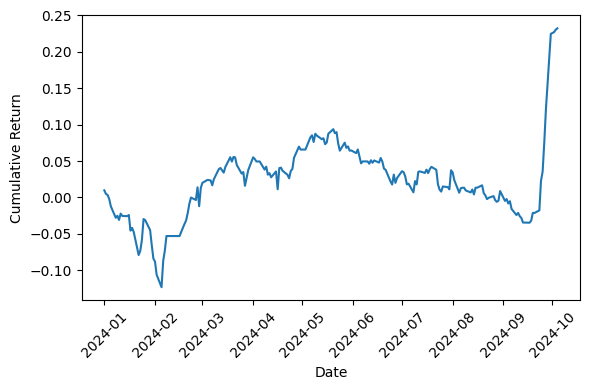

In [13]:
# Group by 'datadate' to compute the aggregated weighted average return across all companies
aggregated_returns = df.groupby('datadate').apply(
    lambda group: group['weighted_return'].sum() / group['mktcap'].sum()
).reset_index(name='aggregated_weighted_return')

# Compute the cumulative return across all companies
aggregated_returns['cumulative_return'] = (1 + aggregated_returns['aggregated_weighted_return']).cumprod() - 1

# Plotting the aggregated cumulative returns over time
plt.figure(figsize=(6, 4))

plt.plot(aggregated_returns['datadate'], aggregated_returns['cumulative_return'], label='All Companies')

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plot24.pdf", format="pdf", bbox_inches="tight")

plt.show()

### **4. Plot Industry Portfolios**

In [14]:
# Create a dictionary for the mappings
industry_mapping = {
    '10': 'Energy',
    '15': 'Materials',
    '20': 'Industrials',
    '25': 'Consumer Discretionary',
    '30': 'Consumer Staples',
    '35': 'Health Care',
    '40': 'Financials',
    '45': 'Information Technology',
    '50': 'Communication Services',
    '55': 'Utilities'
}

# Extract the first two digits of 'gind' and map them to the industry
df['sector'] = df['gind'].astype(str).str[:2].map(industry_mapping)
df

conm    gind  adj_close  \
isin         datadate                                                    
CNE000000BB2 2024-05-02  SINOPEC SHANGHAI PETROCHEM  151010      2.830   
             2024-05-03  SINOPEC SHANGHAI PETROCHEM  151010      2.830   
             2024-10-01  SINOPEC SHANGHAI PETROCHEM  151010      2.990   
             2024-10-02  SINOPEC SHANGHAI PETROCHEM  151010      2.990   
             2024-10-03  SINOPEC SHANGHAI PETROCHEM  151010      2.990   
...                                             ...     ...        ...   
CNE1000054G4 2024-09-27          CHINA ASSET MANAGE    None      1.031   
             2024-09-30          CHINA ASSET MANAGE    None      1.079   
             2024-10-01          CHINA ASSET MANAGE    None      1.079   
             2024-10-02          CHINA ASSET MANAGE    None      1.079   
             2024-10-03          CHINA ASSET MANAGE    None      1.079   

                         daily_return  weighted_return        mktcap  \
isin         datadate                                                  
CNE000000BB2 2024-05-02           NaN              NaN  2.074054e+10   
             2024-05-03      0.000000     0.000000e+00  2.074054e+10   
             2024-10-01      0.056537     1.238906e+09  2.191315e+10   
             2024-10-02      0.000000     0.000000e+00  2.191315e+10   
             2024-10-03      0.000000     0.000000e+00  2.191315e+10   
...                               ...              ...           ...   
CNE1000054G4 2024-09-27      0.024851              NaN           NaN   
             2024-09-30      0.046557              NaN           NaN   
             2024-10-01      0.000000              NaN           NaN   
             2024-10-02      0.000000              NaN           NaN   
             2024-10-03      0.000000              NaN           NaN   

                            sector  
isin         datadate               
CNE000000BB2 2024-05-02  Materials  
             2024-05-03  Materials  
             2024-10-01  Materials  
             2024-10-02  Materials  
             2024-10-03  Materials  
...                            ...  
CNE1000054G4 2024-09-27        NaN  
             2024-09-30        NaN  
             2024-10-01        NaN  
             2024-10-02        NaN  
             2024-10-03        NaN  

[1153081 rows x 7 columns]

/var/folders/bs/5f0ys9r13_l1yqx_3qv0ncg80000gn/T/ipykernel_47213/494638917.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_daily_returns = df.groupby(['datadate', 'sector']).apply(


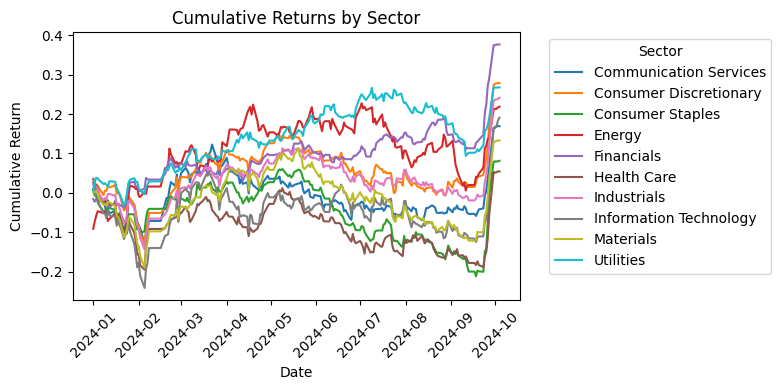

In [15]:
# Group by 'datadate' and 'sector' to compute the weighted average return per sector
weighted_daily_returns = df.groupby(['datadate', 'sector']).apply(
    lambda group: group['weighted_return'].sum() / group['mktcap'].sum()
).reset_index(name='sector_weighted_daily_return')

# Compute the cumulative return for each sector independently
# We ensure the result has the correct index after applying the cumulative product
weighted_daily_returns['cumulative_return'] = weighted_daily_returns.groupby('sector')['sector_weighted_daily_return'].transform(
    lambda x: (1 + x).cumprod() - 1
)

plt.figure(figsize=(8, 4))

for sector in weighted_daily_returns['sector'].unique():
    sector_data = weighted_daily_returns[weighted_daily_returns['sector'] == sector]
    plt.plot(sector_data['datadate'], sector_data['cumulative_return'], label=sector)

plt.title('Cumulative Returns by Sector')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plot25.pdf", format="pdf", bbox_inches="tight")

plt.show()
